# Разработка системы распознавания предметов интерьера в потоковом видео

## Часть 3: Перекодирование масок

In [1]:
%matplotlib inline

#System
import os
import shutil
import random

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imshow, imsave

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [2]:
from scripts_.PathFinder import PathFinder
from scripts_.SegEncoder import SegEncoder
from scripts_.ClassList import ClassList

pf = PathFinder()
se = SegEncoder()
cl = ClassList()

img_dir = 'data/ADE20K_filtred/images/'

### 1. Подготовка данных

Считаем ранее подготовленные правила кодирования классов

Создадим словарь перевода старых индексов в новые

In [3]:
index_old_to_new_dict = cl.get_old_to_new_dict()
se.load_index_dict(index_old_to_new_dict)

### 2. Перекодирование масок

In [4]:
dir_path = 'data/ADE20K_original/images/training/b/bedroom/'
name = "ADE_train_00000218.jpg"

In [5]:
img = imread(dir_path + pf.get_img(name))
seg = imread(dir_path + pf.get_seg(name))
new_seg = se.get_encoded_seg(seg)

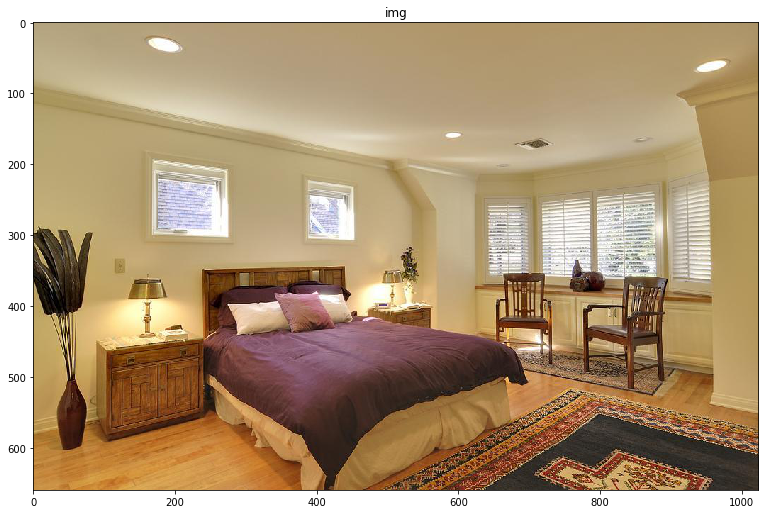

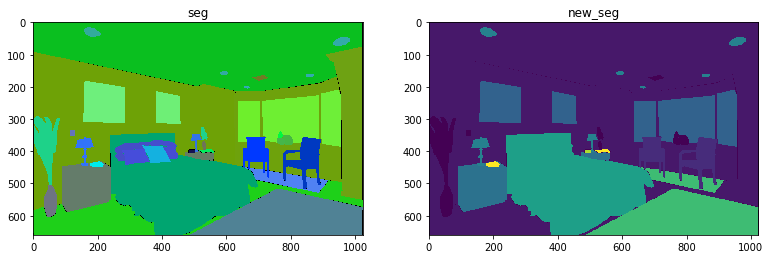

In [6]:
# Изображение
plt.figure(figsize=(13, 10))
plt.imshow(img), plt.title("img")
plt.show()

# Маски
plt.figure(figsize=(13, 10))
plt.subplot(121), plt.imshow(seg), plt.title("seg")
plt.subplot(122), plt.imshow(new_seg), plt.title('new_seg')
plt.show()

### Генерирование новой обучающей выборки

In [7]:
%%time

dir_src = 'data/ADE20K_filtred/images/train/'
dir_dst = 'data/ADE20K_encoded/'

se.encode_dataset(dir_src, dir_dst, update_current_dir=True, progress_step=250)

Size: 7166


KeyboardInterrupt: 